# Import, Init

In [1]:
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print('Error')
        print(e)

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-m8upapwe because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [3]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

NULLS in data -->  0
>>> train-test inited:  
 	X_train len -->  1997 y_train len -->  1997 
 	X_test len -->  1996 y_test len -->  1996 
 	NULLS in data -->  0


In [4]:
# loaded

nn_manager_cut.X_test.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'NTRAT_CH_PDAY'],
      dtype='object')

In [5]:
# nn_manager_cut.X_test.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], 
#                            inplace=True, errors='ignore')
# nn_manager_cut.X_train.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], 
#                             inplace=True, errors='ignore')

## SR: MWNUS_CH_PDAY is not refreshed in the source DS => supplies nulls for last week
nn_manager_cut.X_test.drop(columns=[ 'MWNUS_CH_PDAY', 'Open', 'Next_day_Price'], inplace=True, errors='ignore')
nn_manager_cut.X_train.drop(columns=[ 'MWNUS_CH_PDAY', 'Open', 'Next_day_Price'], inplace=True, errors='ignore')

nn_manager_cut.X_train.columns

Index(['High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'NTRAT_CH_PDAY'],
      dtype='object')

In [6]:
nn_manager_cut.count_nulls_in_data()

NULLS in data -->  0


# Preparing data

#### Swapping (the trial issue)
[[to #Model-fit]](#Model-fit)

In [7]:
tmp = nn_manager_cut.X_test.copy()
nn_manager_cut.X_test = nn_manager_cut.X_train.copy()
nn_manager_cut.X_train = tmp.copy()

tmp = nn_manager_cut.y_test.copy()
nn_manager_cut.y_test = nn_manager_cut.y_train.copy()
nn_manager_cut.y_train = tmp.copy()

print("X_train => ", nn_manager_cut.X_train.shape[0])
print("X_test => ", nn_manager_cut.X_test.shape[0])
print("\ttrain data period => ", nn_manager_cut.X_train.index.min(), "-->", nn_manager_cut.X_train.index.max())
print("\ttest data period => ", nn_manager_cut.X_test.index.min(), "-->", nn_manager_cut.X_test.index.max())

X_train =>  1996
X_test =>  1997
	train data period =>  2016-01-05 00:00:00 --> 2021-06-22 00:00:00
	test data period =>  2010-07-18 00:00:00 --> 2016-01-04 00:00:00


#### Keeping Left-off Samples Aside

In [8]:
hould_out_days = 28
hold_out_X = nn_manager_cut.X_train[-hould_out_days:].copy()
nn_manager_cut.X_train = nn_manager_cut.X_train[:-hould_out_days]

hold_out_y = nn_manager_cut.y_train[-hould_out_days:].copy()
nn_manager_cut.y_train = nn_manager_cut.y_train[:-hould_out_days]

print("X_train, X_test --> ", nn_manager_cut.X_train.shape[0], nn_manager_cut.X_test.shape[0])
print("Holdout period --> ", hold_out_X.index.min(), "-->", hold_out_X.index.max())

X_train, X_test -->  1968 1997
Holdout period -->  2021-05-26 00:00:00 --> 2021-06-22 00:00:00


## Normalizing

In [9]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

nn_manager_cut.normalize_X(scaler=RobustScaler)
# nn_manager_cut.transform_X(transformer=QuantileTransformer)

# ### tmp ### 
# nn_manager_cut.X_train_normalized = nn_manager_cut.X_train.values 
# nn_manager_cut.X_test_normalized = nn_manager_cut.X_test.values 

(
    nn_manager_cut.X_train_normalized[:2], 
    nn_manager_cut.X_train_transformed
)

(array([[-0.77874944, -0.77521961, -0.24338513, -0.34523757, -0.32592708,
         -1.04644807, -0.87741575,  1.89569161, -0.07146838, -1.85743758],
        [-0.77913864, -0.77571433, -0.24673841, -0.22901301, -0.34811658,
         -0.91552175, -0.87626529,  0.97052154,  0.01219552,  0.10108965]]),
 None)

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

#### Setting sequence len

In [10]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=1))

self.training_seq_params -->  {'seq_len': 1, 'n_features': 10}
self.X_train_shape -->  [1, 10]
self.X_test_shape -->  [1, 10]


True

In [11]:
nn_manager_cut.unroll_train_test_to_sequences()

True

In [12]:
# goes up by one sequence -- compare this cell result vs previous

print("X_unrolled [0] -->\n", nn_manager_cut.X_train_unrolled[0], '\t=>', nn_manager_cut.y_train_unrolled[0])
print("\nX_unrolled [1] -->\n", nn_manager_cut.X_train_unrolled[1], '\t=>', nn_manager_cut.y_train_unrolled[1])
print("\nX_unrolled [2] -->\n", nn_manager_cut.X_train_unrolled[2], '\t=>', nn_manager_cut.y_train_unrolled[2])

X_unrolled [0] -->
 [[-0.77874944 -0.77521961 -0.24338513 -0.34523757 -0.32592708 -1.04644807
  -0.87741575  1.89569161 -0.07146838 -1.85743758]] 	=> [430.8]

X_unrolled [1] -->
 [[-0.77913864 -0.77571433 -0.24673841 -0.22901301 -0.34811658 -0.91552175
  -0.87626529  0.97052154  0.01219552  0.10108965]] 	=> [457.]

X_unrolled [2] -->
 [[-0.77604933 -0.77527035 -0.06488594 -0.06535479 -0.30659308 -0.93628388
  -0.87561474  1.33333333  1.17103236 -0.91053213]] 	=> [452.9]


In [13]:
# on the base of the first {seq_len} elements of the sequence we want to predict the next day price

nn_manager_cut.y_train.iloc[:6], nn_manager_cut.y_train_unrolled[:6]

(            Price
 Date             
 2016-01-05  431.2
 2016-01-06  430.8
 2016-01-07  457.0
 2016-01-08  452.9
 2016-01-09  448.3
 2016-01-10  446.2,
 array([[430.8],
        [457. ],
        [452.9],
        [448.3],
        [446.2],
        [447.7]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [14]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### DenseNN-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [15]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(1, 10)

In [16]:
# LSTM Architecture for hard periods train-test split

weights_init = GlorotNormal()

template_DNS = [
    Flatten(input_shape=(nn_manager_cut.training_seq_params['seq_len'], 
                       nn_manager_cut.training_seq_params['n_features'])
           ),
    Dense(150, 
          activation=LeakyReLU(alpha=0.3),          
          kernel_initializer=weights_init
         ),
    Dense(450, 
          activation=LeakyReLU(alpha=0.3),
          kernel_initializer=weights_init
         ),
    Dense(250, 
      activation=LeakyReLU(alpha=0.3),
      kernel_initializer=weights_init
     ),
    Dense(50, 
      activation=LeakyReLU(alpha=0.3),
      kernel_initializer=weights_init
     ),
    Dense(1, kernel_initializer=weights_init)
]

In [17]:
nn_manager_cut.X_train_unrolled.shape

(1967, 1, 10)

### Compiling Model with the chosen Architecture

In [18]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=5e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_DNS, compile_dict=compile_dict)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 150)               1650      
_________________________________________________________________
dense_1 (Dense)              (None, 450)               67950     
_________________________________________________________________
dense_2 (Dense)              (None, 250)               112750    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                12550     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 194,951
Trainable params: 194,951
Non-trainable params: 0
_______________________________

True

## Model Training

#### Model fit

In [19]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([1967, 1, 10], [1996, 1, 10])

CPU times: user 1min 17s, sys: 10.7 s, total: 1min 28s
Wall time: 30.4 s


(0.0, 2000.0)

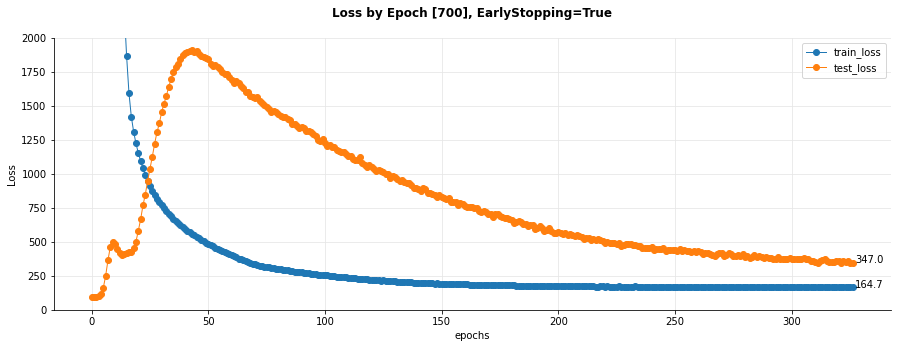

In [20]:
%%time
res = nn_manager_cut.model_fit(n_epoch=700,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#DenseNN-based]](#DenseNN-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

Train-Test split after swapping data [[go]](#Swapping-(the-trial-issue))

# Saving Model

In [21]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_DNSe_working')

In [22]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210623_20H39M34S_192_Bidi_2d/')

### Plotting 

In [23]:
hold_out_X[:3]

,High,Low,Vol,TOUTV,TRFEE,AVBLS,NTRAT,BTC_MINED_PDAY,VOL_CHANGE_PDAY,NTRAT_CH_PDAY
Date,,,,,,,,,,
2021-05-26,40750.0,37847.0,153800.0,2.222384e+06,77.846658,1.300155,644838441.0,756.25,-9210.0,233414.0
2021-05-27,40322.2,37190.8,122930.0,1.982669e+06,66.114770,1.262394,645069798.0,718.75,-30870.0,231357.0
2021-05-28,38844.1,34772.4,199580.0,2.897052e+06,69.535068,1.343872,645284958.0,831.25,76650.0,215160.0


In [24]:
hold_out_X_unrolled, hold_out_y_unrolled = nn_manager_cut.unroll_train_test_to_sequences(
    X=nn_manager_cut.scaler.transform(hold_out_X), 
    y =hold_out_y.values
)

hold_out_X_unrolled[-1:], hold_out_X_unrolled.shape[0]

>>> Method called with outer X and y. Returning X, y unrolled...


(array([[[ 3.51139031,  3.13880062,  0.20058892,  0.10895243,
          -0.24105458,  1.12643905,  1.12989766, -0.79818594,
           1.59879356, -1.00051624]]]),
 27)

In [25]:
left_off_date_index = hold_out_y.index[nn_manager_cut.training_seq_params['seq_len']:]
left_off_date_index

DatetimeIndex(['2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
               '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
               '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
               '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
               '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15',
               '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19',
               '2021-06-20', '2021-06-21', '2021-06-22'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [26]:
left_off_pred = [nn_manager_cut.model_predict(seq.reshape(1,
                                                   nn_manager_cut.training_seq_params['seq_len'],
                                                   nn_manager_cut.training_seq_params['n_features']))[0][0]
                 for seq in hold_out_X_unrolled]
left_off_pred[:2]

[39490.836, 38924.223]

In [38]:
hold_out_y_df = pd.DataFrame(data=hold_out_y_unrolled, index=left_off_date_index, columns=["holdout Y"])
hold_out_pred_df = pd.DataFrame(data=left_off_pred, index=left_off_date_index, columns=["holdout Pred"])

In [42]:
hold_out_y_df[:5]

,holdout Y
Date,
2021-05-27,38417.3
2021-05-28,35662.5
2021-05-29,34584.6
2021-05-30,35652.8
2021-05-31,37298.6


In [43]:
hold_out_pred_df[:5]

,holdout Pred
Date,
2021-05-27,39490.835938
2021-05-28,38924.222656
2021-05-29,37028.613281
2021-05-30,35573.382812
2021-05-31,34924.308594


<AxesSubplot:xlabel='Date'>

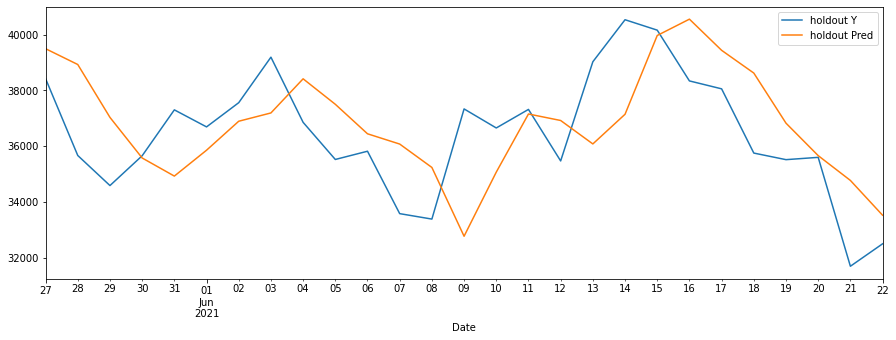

In [45]:
fig, ax = plt.subplots(1, figsize=(15,5))

hold_out_y_df.plot(ax=ax)
hold_out_pred_df.plot(ax=ax)

## think about this tomorrow
https://monosnap.com/file/bLcjLWpyUcocdmuraTyJNIWkKZLhOh

In [28]:
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.02.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"], legend_loc='upper left') 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2014-11-01'", "Date<='2014-12-01'"]) 


# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.06.09'", "Date<='2021.06.17'"]) 

In [29]:
# X = nn_manager_cut.X_test['2021-06-10':'2021-06-11']
# X = nn_manager_cut.scaler.transform(X)
# nn_manager_cut.model_predict(X.reshape(1, nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0] 

In [30]:
# nn_manager_cut.y_test.loc['2021-06-12']

In [31]:
# data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.07':'2018.06.09'])
# nn_manager_cut.model_predict(data_for_pred.reshape(1,
#                                                   nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0]


In [32]:
# nn_manager_cut.y_test.loc['2018.06.09']

In [33]:
# nn_manager_cut.y_test_unrolled[:3]

In [34]:
# nn_manager_cut.y_pred[:3]

In [35]:
# nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:][:3]